# exp006  
[Notion](https://www.notion.so/exp006-b56091f372f149d581160348c313be1c?pvs=4)  
データセット作成時のdicom画像のオーバーフローを修正  

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import nibabel as nib
import warnings
from tqdm import tqdm

%matplotlib inline
warnings.filterwarnings("ignore")

# リポジトリtopに移動
while os.path.basename(os.getcwd()) != 'rsna-2023':
    os.chdir('../')
    if os.getcwd() == '/':
        raise Exception('Could not find project root directory.')
    
from src.data_io import load_dicom_series

In [5]:
dicombasedir = "data/rsna-2023-abdominal-trauma-detection/train_images"
# 問題の患者(の一例)
pid, sid = 10172, 50253

series_dir = os.path.join(dicombasedir, str(pid), str(sid))

In [6]:
series_dir

'data/rsna-2023-abdominal-trauma-detection/train_images/10172/50253'

In [7]:
for path in os.listdir(series_dir):
    dicom = pydicom.dcmread(os.path.join(series_dir, path))
    img = dicom.pixel_array
    break

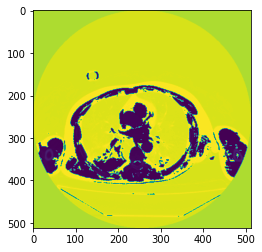

In [8]:
plt.imshow(img)

In [15]:
def standardize_pixel_array(dcm: pydicom.dataset.FileDataset) -> np.ndarray:
    """特殊なデータ格納方式の場合にビットシフトを適用する.
    Reference:
        https://www.kaggle.com/competitions/rsna-2023-abdominal-trauma-detection/discussion/427217
    """
    # Correct DICOM pixel_array if PixelRepresentation == 1.
    pixel_array = dcm.pixel_array
    if dcm.PixelRepresentation == 1:
        bit_shift = dcm.BitsAllocated - dcm.BitsStored
        dtype = pixel_array.dtype 
        pixel_array = (pixel_array << bit_shift).astype(dtype) >>  bit_shift
    return pixel_array

In [16]:
for path in os.listdir(series_dir):
    dicom = pydicom.dcmread(os.path.join(series_dir, path))
    img = standardize_pixel_array(dicom)
    break

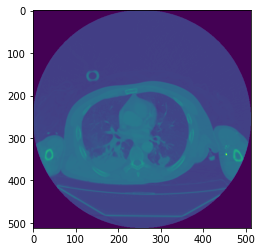

In [17]:
plt.imshow(img)

In [19]:
bit_shift = dicom.BitsAllocated - dicom.BitsStored
print(bit_shift)

3


In [2]:
df_train = pd.read_csv('data/rsna-2023-abdominal-trauma-detection/train.csv')
df_train_image_level = pd.read_csv('data/rsna-2023-abdominal-trauma-detection/image_level_labels.csv')
df_train_serirs_meta = pd.read_csv('data/rsna-2023-abdominal-trauma-detection/train_series_meta.csv')

base_dir = "data/rsna-2023-abdominal-trauma-detection"
dataset_dir = "data/dataset001"

In [6]:
# dataset001の、該当するデータを上書きする
# ソースコード修正済み(`data_io.py`)のため、新規にexp002.ipynbからデータセットを作成する場合は、このファイルは不要
for idx, (pid, sid) in tqdm(enumerate(zip(df_train_serirs_meta["patient_id"], df_train_serirs_meta["series_id"]))):
    series_path = os.path.join(base_dir, "train_images", str(pid), str(sid))
    any_path = os.listdir(series_path)[0]
    dicom = pydicom.read_file(os.path.join(series_path, any_path))
    if dicom.PixelRepresentation == 1:
        bit_shift = dicom.BitsAllocated - dicom.BitsStored
        if bit_shift != 0:
            image_arr, path_list, meta_list = load_dicom_series(series_path)
            output_dir = os.path.join(dataset_dir, "train_images", str(pid), str(sid))
            os.makedirs(output_dir, exist_ok=True)
            for idx, path in enumerate(path_list):
                path = path.replace(".dcm", ".npy")
                np.save(os.path.join(output_dir, path), image_arr[idx])

4711it [18:26,  4.26it/s]
